# Candidature de stage appliquée à la diabétologie APHP DSI
L'objectif de ce notebook est de fournir un support technique à ma candidature attestant de mes compétences en Data Science. Pour illustrer mes capacités d'analyse et de modélisation, j'ai choisi de travailler avec un dataset en lien avec le sujet du stage : Pima Indians Diabetes Database (accessible sur Kaggle)

## Présentation du Pima Indians Diabetes Database
Le Pima Indians Diabetes Database provient d'une étude menée par le National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK) aux États-Unis. Il s'agit d'une base de données recueillie auprès de femmes de la communauté amérindienne Pima, dans le but d'explorer la prévalence du diabète de type 2 au sein de cette population.

## Caractéristiques du Dataset
Cet ensemble de données comprend plusieurs caractéristiques médicales qui peuvent être cruciales pour l'analyse diabétologique et la création de modèles prédictifs.

### Features
- Âge
- Nombre de grossesses
- Pression artérielle
- Épaisseur du pli cutané
- Concentration de glucose dans le plasma
- Indice de masse corporelle (IMC)
- ... et d'autres mesures pertinentes
- 
### Variable Cible
La variable cible de cet ensemble de données est binaire, indiquant la présence ou l'absence de diabète chez les femmes Pima.

## Objectif du Projet
1) Réaliser une analyse détaillée du dataset
2) Développer un modèle permettant de détecter le diabète
3) Identifier des sous-groupes de patients en fonction de leurs caractéristiques

## Imports

In [1]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Manipulation des données
import numpy as np
import pandas as pd

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Scoring Librairies
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from scikeras.wrappers import KerasClassifier 
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

2024-02-24 17:53:26.900690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 17:53:27.031987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1) Preprocessing

#### Récupération du dataset

In [2]:
datadir = os.path.join(os.getcwd(), 'dataset')
data_df = pd.read_csv(os.path.join(datadir, 'diabetes.csv'))

In [3]:
# Premières lignes du dataframe
data_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Vérification des valeurs manquantes

In [4]:
data_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

La méthode isnull() permet de vérifier qu'il n'y a pas de "valeurs manquantes".
On verra ci-dessous qu'en pratique ce n'est pas réellement le cas.

In [5]:
# Informations sur les différentes features
data_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


On constate des valeurs à 0 dans les colonnes SkinThickness, Insulin, BMI, Glucose, BloodPressure
Cela ne fait pas de sens sauf si les valeurs manquantes ont été initialisées à 0. Il va falloir traiter ces cas particulier.

In [6]:
# Nouveau calcul des valeurs manquantes
data_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)
data_df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Cette fois on a une vraie interprétation des valeurs manquantes:
- 5 pour le glucose
- 35 pour le blood pressure
- 227 pour skin thickness
- 374 pour l insulin
- 11 pour BMI

Afin décider de la stratégie à adapter pour remplacer ces valeurs manquantes il est intéressant d'étudier la distribution des features.

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

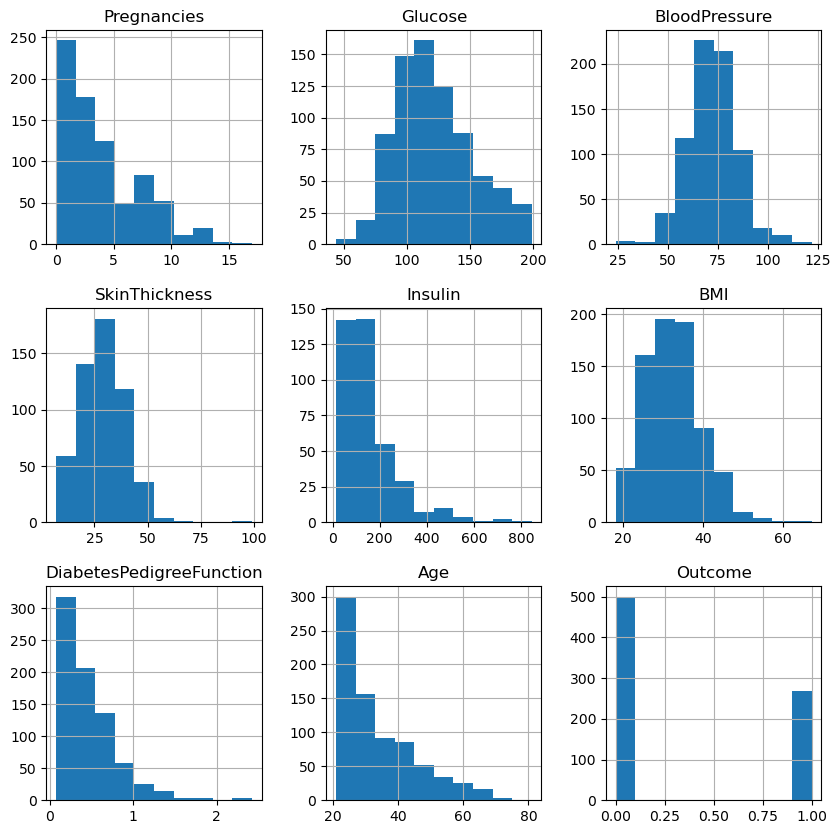

In [7]:
data_df.hist(figsize = (10,10))

On observe une distribution :
1) Normale pour Glucose, BloodPressure et SkinTchikness -> valeurs manquantes remplacées par la moyenne
2) _ pour BMI et Insulin -> valeurs manquantes remplacées par la médianes (cela permet d'être moins sensible à présence d'outliers)

In [8]:
# Correction du jeu de données
# Mean
data_df['Glucose'].fillna(data_df['Glucose'].mean(), inplace=True)
data_df['SkinThickness'].fillna(data_df['SkinThickness'].mean(), inplace=True)
data_df['BloodPressure'].fillna(data_df['BloodPressure'].mean(), inplace=True)

# Median
data_df['Insulin'].fillna(data_df['Insulin'].median(), inplace=True)
data_df['BMI'].fillna(data_df['BMI'].median(), inplace=True)

#### Etude des valeurs aberrantes

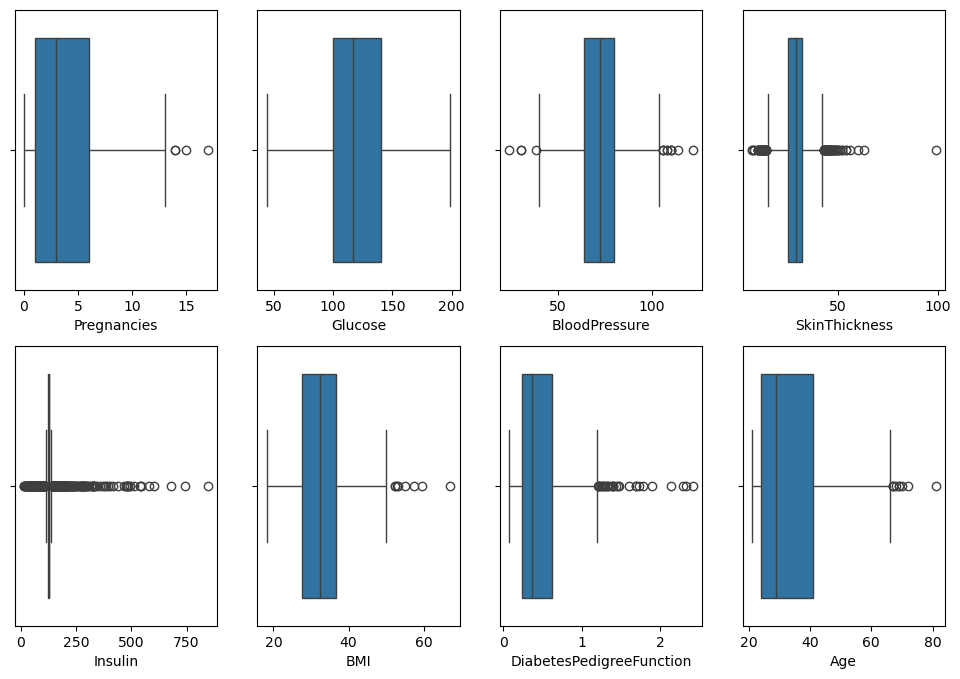

In [9]:
features = data_df.columns.drop('Outcome')

fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=4)

for i, feature in enumerate(features):
    sns.boxplot(x=data_df[feature], ax=ax[i//4, i%4])
    
plt.show()

De nombreaux plots suggèrent la présence de valeurs aberrantes. Il serait nécessaire d'effectuer une investigation précise pour les features DiabetesPedigreeFunction, Insulin, SkinThickness, Age, BMI, BloodPressure, Pregnancies.

Remarque : Pour des questions de temps je ne me concentrerai pas sur ces notions. Il faudrait réaliser des tests plus précis : Z-score, Robust Z-score, etc.

#### Analyse de la disparité entre les classes

Text(0.5, 1.0, 'Distribution de la variable Diabetes')

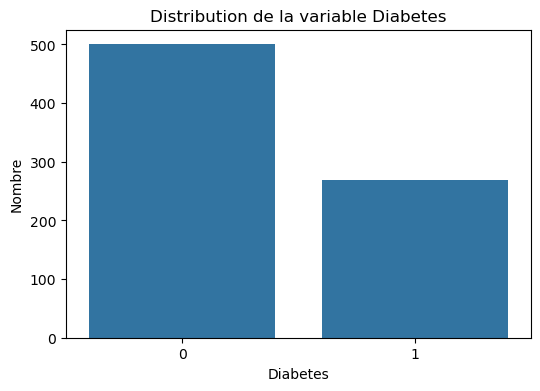

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=data_df)
plt.xlabel('Diabetes')
plt.ylabel('Nombre')
plt.title('Distribution de la variable Diabetes')

On constate qu'il y a une disparité modérée entre les classe avec deux fois plus de personnes qui n'ont pas le diabètes.
Il faudra exploiter d'autres métriques que l'accuracy (precision, recall, f1 score, ...) afin de mesurer la performance de notre modèle.

#### Etude de la corrélation entre les variables

<Figure size 1200x1000 with 0 Axes>

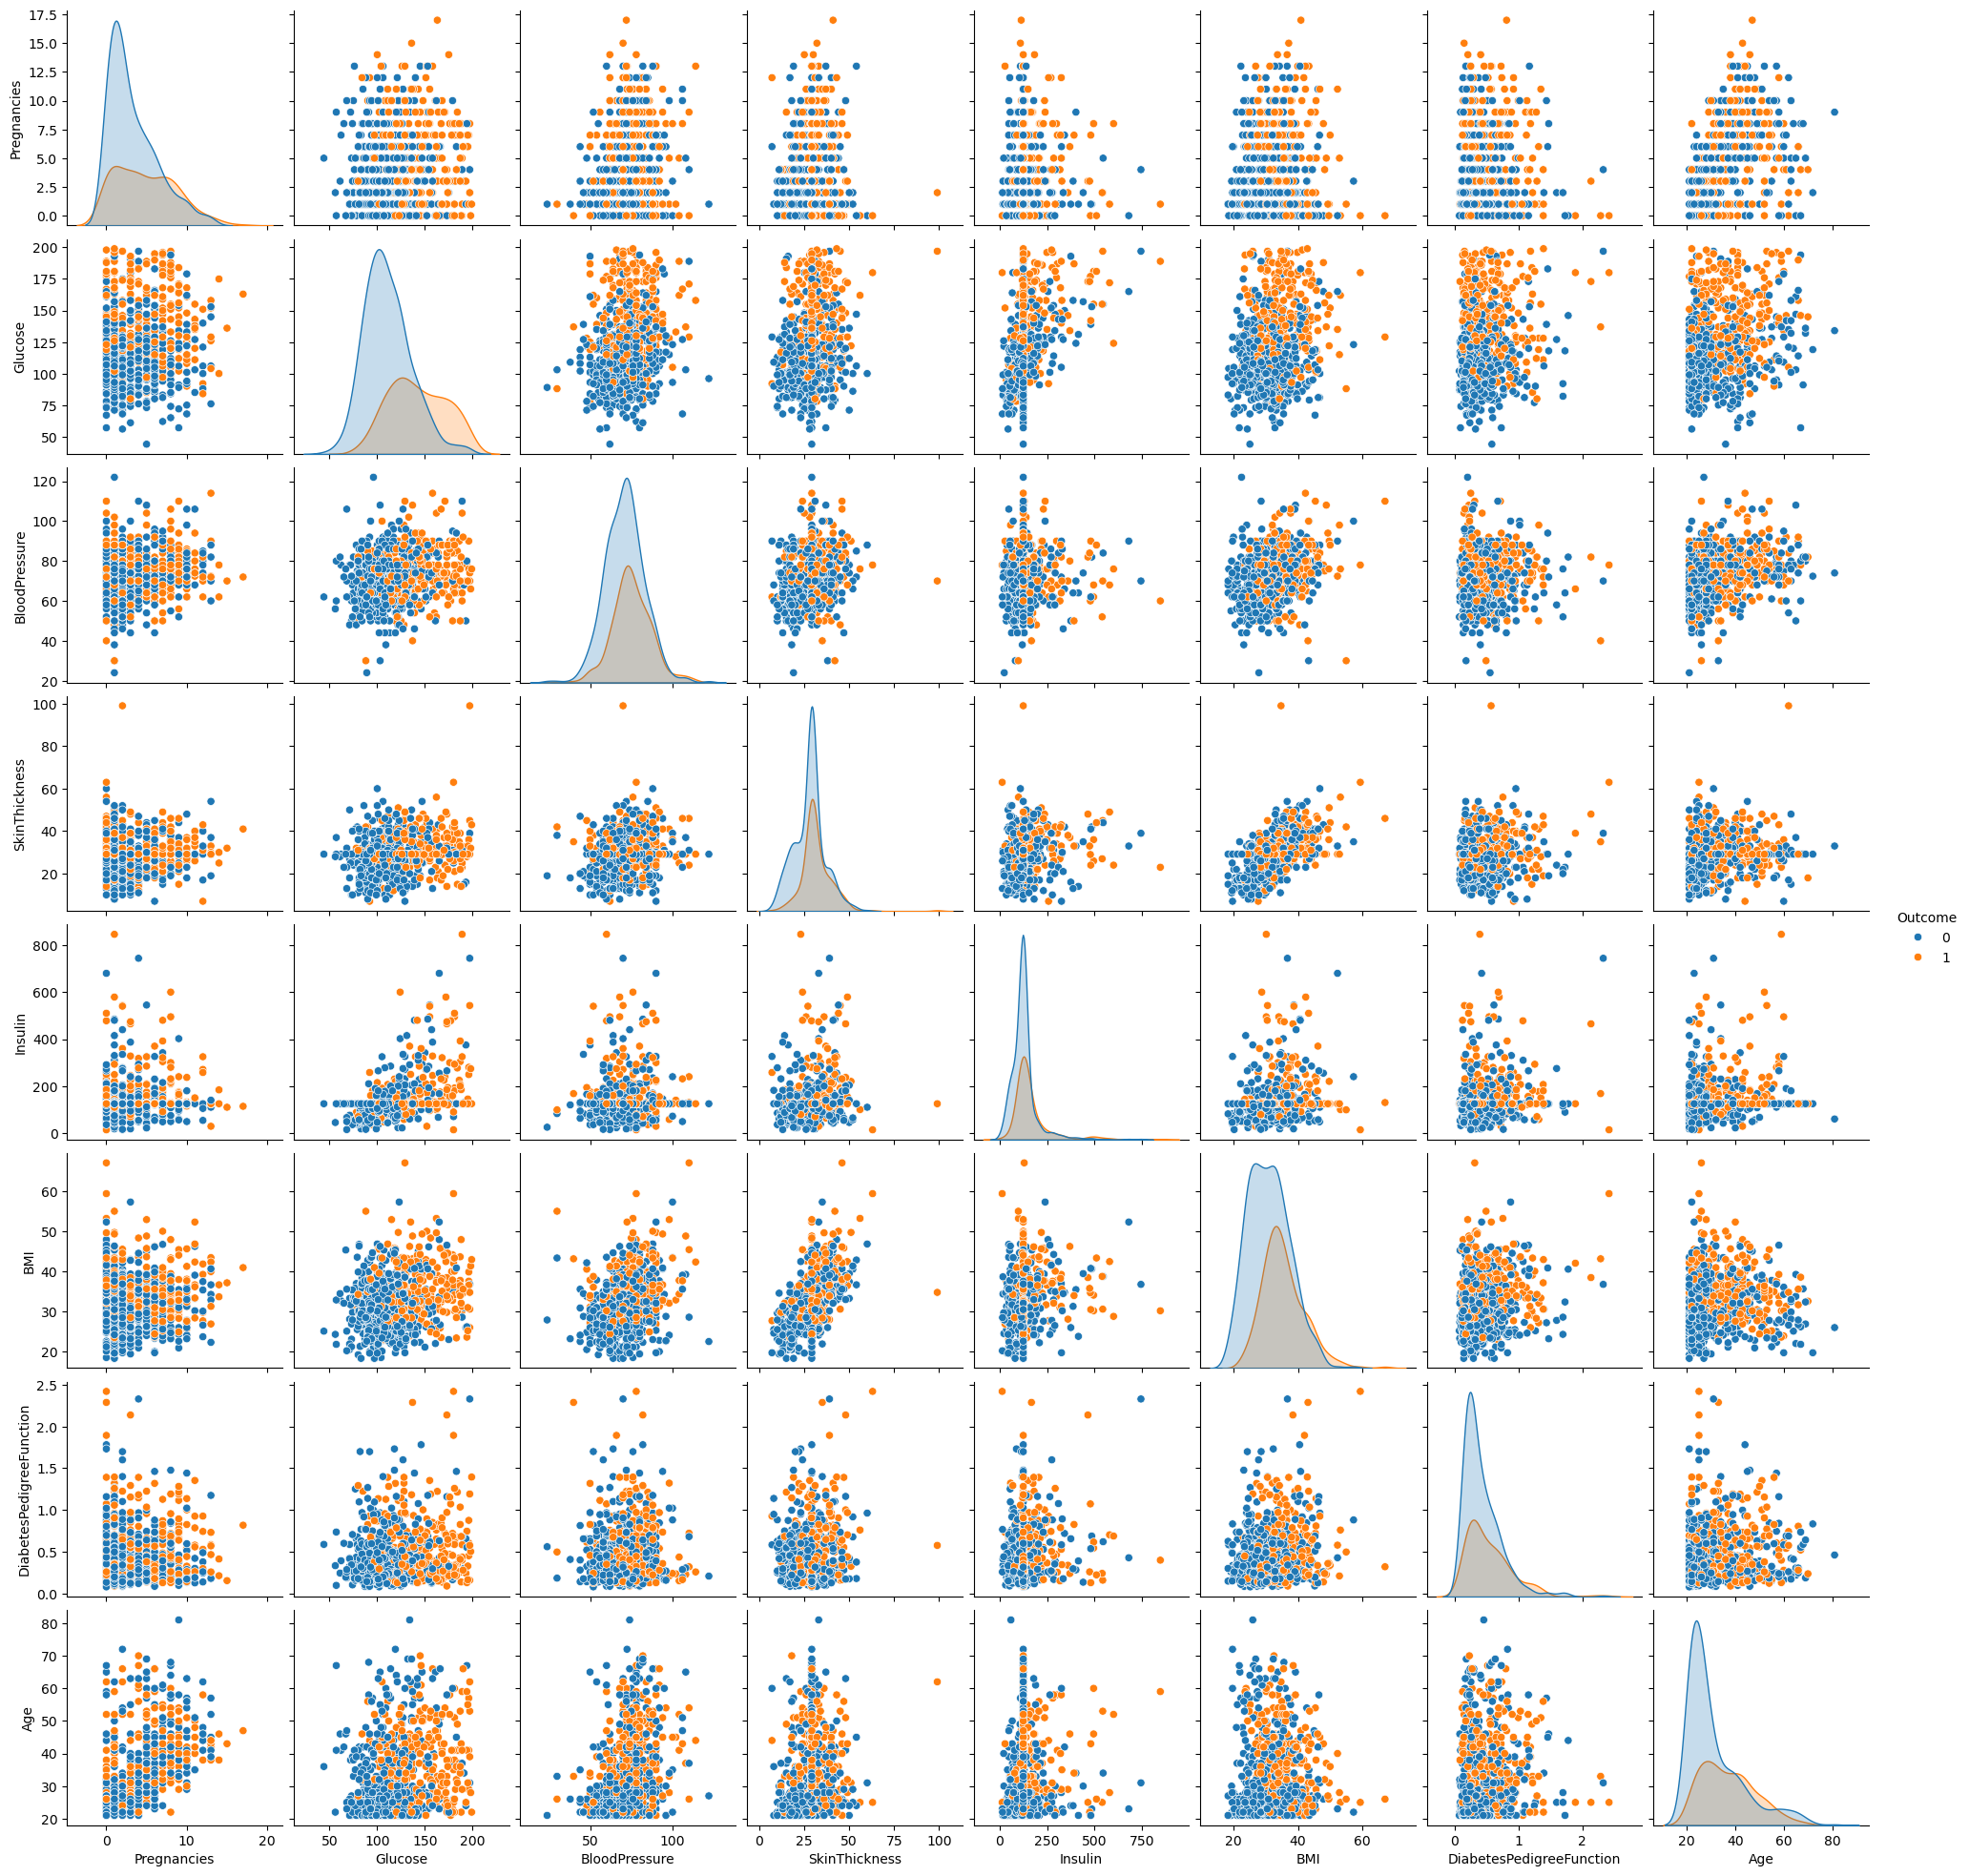

In [11]:
# Pair plot
plt.figure(figsize=(12,10))
sns.pairplot(data_df, hue = 'Outcome')

In [12]:
plt.figure(figsize=(10,10))
data_df.corr()

#p=sns.heatmap(data_df.corr(), annot=True,cmap ='Reds')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.127911,0.208522,0.082989,0.025047,0.021559,-0.033523,0.544341,0.221898
Glucose,0.127911,1.000000,0.218367,0.192991,0.419064,0.231128,0.137060,0.266534,0.492928
BloodPressure,0.208522,0.218367,1.000000,0.192816,0.045087,0.281199,-0.002763,0.324595,0.166074
SkinThickness,0.082989,0.192991,0.192816,1.000000,0.154678,0.542438,0.100966,0.127872,0.215299
Insulin,0.025047,0.419064,0.045087,0.154678,1.000000,0.180241,0.126503,0.097101,0.203790
BMI,0.021559,0.231128,0.281199,0.542438,0.180241,1.000000,0.153438,0.025597,0.312038
DiabetesPedigreeFunction,-0.033523,0.137060,-0.002763,0.100966,0.126503,0.153438,1.000000,0.033561,0.173844
Age,0.544341,0.266534,0.324595,0.127872,0.097101,0.025597,0.033561,1.000000,0.238356
Outcome,0.221898,0.492928,0.166074,0.215299,0.203790,0.312038,0.173844,0.238356,1.000000


<Figure size 1000x1000 with 0 Axes>

On remarque que les corrélations suivantes sont "élevées":
- Age et Pregnancies : Coefficient de corrélation = 0.544341
- Glucose et Outcome : Coefficient de corrélation = 0.492928
- BMI et SkinThickness : Coefficient de corrélation = 0.542438
- Glucose et Insulin : Coefficient de corrélation = 0.419064

Remarque : problème graphique pour la heatmap (à résoudre)

#### Train test split

In [13]:
target = 'Outcome'
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Définition du trainset et du testset
X, y = data_df[features], data_df[target]
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

X_train

array([[ 0.93138344,  2.08575258,  0.96551752, ...,  0.42891002,
        -0.37477883,  0.63212912],
       [ 0.63260632, -1.22286662,  0.47271619, ..., -0.21055029,
        -0.29416766,  0.71699246],
       [-0.56250219, -0.52103831, -0.67715357, ..., -0.31464848,
         2.74517192,  0.03808578],
       ...,
       [-0.86127931, -0.82182187, -0.18435224, ...,  0.81556043,
        -0.78380586, -0.30136756],
       [ 0.63260632,  2.28627496,  1.62258595, ...,  0.42891002,
        -0.60466993,  2.75371249],
       [ 0.03505207,  0.74893674, -1.16995489, ..., -0.46336018,
        -0.57779954,  0.29267578]])

## 2) Modèle permettant de détecter le diabète

## Machine Learning

#### Sélection du meilleur KNN selon le score F1

In [14]:
# Créer un modèle k-NN
knn = KNeighborsClassifier()

# Paramètres à tester
k_range = list(range(1, 100))
param_grid = {'n_neighbors': k_range}

# GridSearchCV pour sélectionner le meilleur modèle selon le score F1
grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1', return_train_score=False)
grid.fit(X_train, Y_train)

best_knn = grid.best_estimator_

Le score F1 est particulièrement intéressant car il prend en compte à la fois la précision (capacité à ne pas classer à tort en positif) et le rappel (capacité à trouver tous les exemples positifs) dans une seule métrique. Cela en fait une mesure équilibrée qui est pertinente lorsque les classes sont déséquilibrées comme ici.

On cherche à optimiser un compromis entre la précision et le rappel, offrant ainsi un équilibre entre la sensibilité et la spécificité du modèle.

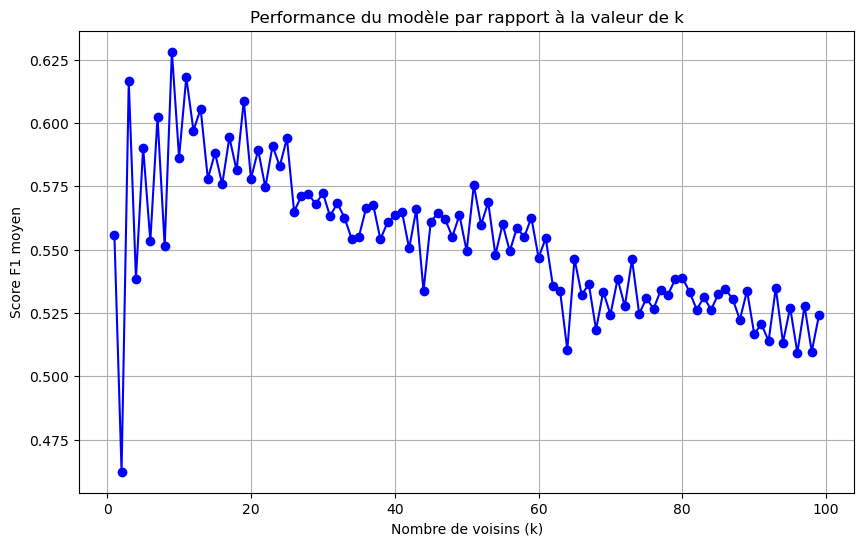

In [15]:
results = grid.cv_results_

# Extraire les valeurs de k et les scores F1 correspondants
k_values = results['param_n_neighbors'].data.astype(int)
f1_scores = results['mean_test_score']

# Tracer la performance du modèle par rapport à la valeur de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o', linestyle='-', color='b')
plt.title('Performance du modèle par rapport à la valeur de k')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score F1 moyen')
plt.grid(True)
plt.show()

#### Etude de la performance du meilleur KNN sur le jeu de test

In [16]:
# Fit du meilleur modèle sur le trainset complet
best_knn.fit(X_train, Y_train)
y_predict = best_knn.predict(x_test)

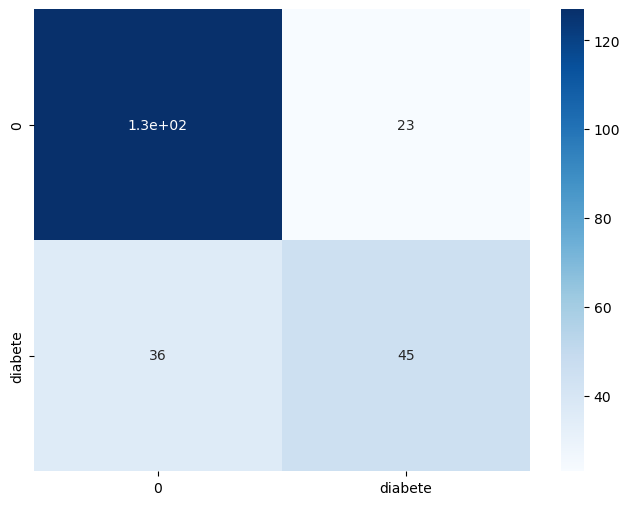

In [17]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
s = sns.heatmap(cm, annot=True, cmap='Blues',
               xticklabels=['0', 'diabete'],
               yticklabels=['0', 'diabete'])
plt.show();

Problème heatmap : score ligne du bas 36 ; 45

In [18]:
# Classification report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       150
           1       0.66      0.56      0.60        81

    accuracy                           0.74       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.74      0.74      0.74       231



Pour la classe 0 (absence de diabète), le modèle a obtenu une précision de 78%, indiquant que 78% des prédictions positives étaient correctes parmi toutes les prédictions positives faites par le modèle pour cette classe. Le rappel (sensibilité) pour la classe 0 est de 85%, signifiant que le modèle a correctement identifié 85% de toutes les instances réellement positives pour cette classe. Le score F1 de 0.81 indique un bon équilibre entre précision et rappel. En ce qui concerne la classe 1 (présence de diabète), la précision est de 66%, montrant que 66% des prédictions positives pour cette classe étaient correctes. Le rappel pour la classe 1 est de 56%, indiquant que le modèle a réussi à capturer 56% de toutes les occurrences réellement positives pour cette classe. Le score F1 de 0.60 souligne un équilibre moins optimal entre précision et rappel pour cette classe.
Le modèle a donc plus de mal a identifier les patients atteints par le diabète.

## Deep Learning

### MLP basique

In [19]:
data_df.shape

(768, 9)

In [20]:
# Création d'un MLP (Multi Layer Perceptron)
model = Sequential()

# Couche d'entrée avec 8 neurones = nb de features
model.add(Input(8))

# Ajout de couches cachées avec une activation relu
model.add(Dense(16, activation='relu'))

# Ajout de la couche de sortie avec 1 neurone et fonction d'activation sigmoid (car classification binaire)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Remarque :
- La sortie de la fonction sigmoid est proche de 0, cela s'interprète comme une probabilité proche de 0%, et si elle est proche de 1, cela s'interprète comme une probabilité proche de 100% d'appartenance à la classe 1
- . La fonction de perte mesure la différence entre les valeurs prédites par le modèle et les valeurs réelles (étiquettes) dans l'ensemble d'entraînement. Dans le cas d'une tâche de classification binaire on utilise fréquemment la "binary crossentropy". Elle mesure la divergence entre la distribution de probabilité prédite par le modèle et la distribution de probabilité réelle des classes.

In [21]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

# Prédictions sur l'ensemble de test
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.7088 - accuracy: 0.5289 - val_loss: 0.6873 - val_accuracy: 0.5714
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.6108 - val_loss: 0.6355 - val_accuracy: 0.6580
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6064 - accuracy: 0.6965 - val_loss: 0.5998 - val_accuracy: 0.6883
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.5742 - accuracy: 0.7412 - val_loss: 0.5719 - val_accuracy: 0.7056
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.5475 - accuracy: 0.7505 - val_loss: 0.5519 - val_accuracy: 0.7143
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.5271 - accuracy: 0.7561 - val_loss: 0.5363 - val_accuracy: 0.7273
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.5113 - accuracy: 0.7691 - val_loss: 0.5251 - val_accuracy: 0.7359
Epoch 8/100


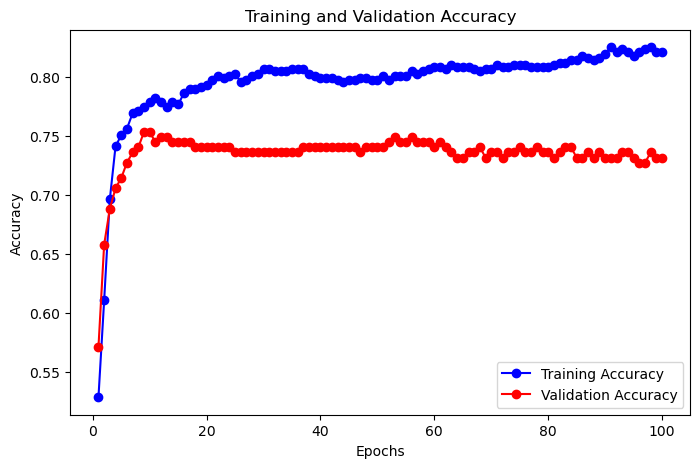

In [22]:
# Extraire les métriques d'entraînement et de validation de l'historique
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes
epochs = range(1, len(train_accuracy) + 1)

# Courbes de précision (accuracy)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

On observe un surajustement du modèle avec une amélioration de sa performance sur le jeu d'entraînement et une stagnation / diminution sur le jeu de test. Ceci est ici du à un nombre d'epochs trop elevé (100).

In [23]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81       150
           1       0.65      0.51      0.57        81

    accuracy                           0.73       231
   macro avg       0.71      0.68      0.69       231
weighted avg       0.72      0.73      0.72       231



On constate que ce réseau de neurones est légèrement moins performant que le KNN : f1-score 0 0.81 <= 0.81 et 1 0.57 < 0.60.
On va essayer d'améliorer notre réseau en modifiant les hyperparamètres et en tenant compte des remarques précédentes sur le surajustement.

### Construction d'un réseau plus performant

In [24]:
start_time = time.time()

# Définition de la grille d'hyperparamètres à tester
params = {
    'batch_size':[20],
    'epochs':[20, 50],
    'model__optimizer': ['adam', 'sgd'],
    'model__activation': ['relu', 'tanh'],
    'model__neurons_1': [8, 16],
    'model__neurons_2': [8, 16]
}

# Fonction pour créer le modèle
def MultiLayerPerceptron(optimizer='adam', activation='relu', neurons_1=16, neurons_2=16):
    model = Sequential()
    model.add(Input(shape=8))
    model.add(Dense(neurons_1, activation=activation))
    model.add(Dense(neurons_2, activation=activation))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.F1Score()])
    return model

model = KerasClassifier(model=MultiLayerPerceptron, verbose=0)

# Création de l'objet GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5)

# Recherche des meilleures hyperparamètres
grid_result = grid.fit(X_train, Y_train)

end_time = time.time()

print("Durée de l'expérience", end_time - start_time)

Durée de l'expérience 243.55157494544983


In [25]:
# Displaying the results
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy score: ", grid_result.best_score_)

Best parameters found:  {'batch_size': 20, 'epochs': 50, 'model__activation': 'tanh', 'model__neurons_1': 16, 'model__neurons_2': 8, 'model__optimizer': 'sgd'}
Best accuracy score:  0.7782796815507095


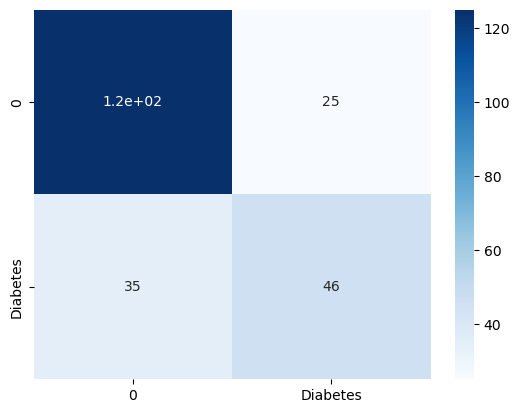

In [26]:
# Récupération du meilleur modèle
best_MLP = grid_result.best_estimator_

# Confusion matrix 
y_pred = best_MLP.predict(x_test)
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap='Blues',
            xticklabels=['0', 'Diabetes'],
            yticklabels=['0', 'Diabetes'])
plt.show();

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       150
           1       0.65      0.57      0.61        81

    accuracy                           0.74       231
   macro avg       0.71      0.70      0.71       231
weighted avg       0.73      0.74      0.74       231



La performance obtenue à la fin de l'expérience n'est pas significativement différente de celle obtenue avec le premier réseau de neurones et du KNN.
Pour conserver une explicabilité des résultats il vaut mieux conserver le modèle KNN. Il sera plus simple d'expliquer les résultats et les facteurs de performances avec cet algorithme.

## 3) Identification de clusters chez les patients

### Un premier clustering

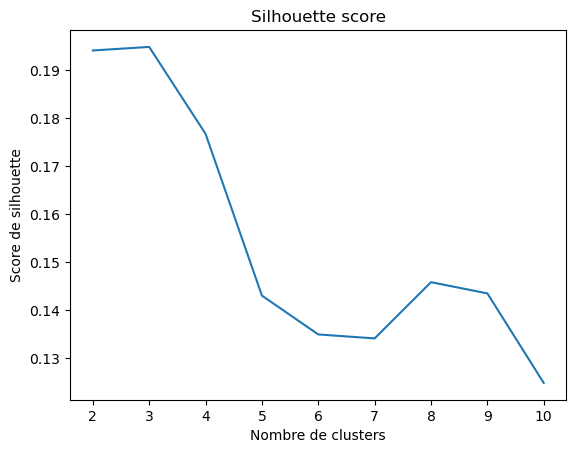

In [28]:
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette score')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()

L'objectif lors de l'utilisation de la méthode de silhouette est de maximiser le score de silhouette. Le score de silhouette est une mesure de la qualité d'un clustering, et il varie de -1 à 1. Plus le score de silhouette est proche de 1, meilleure est la séparation entre les clusters. Donc dans notre cas il faudra utiliser n = 2 clusters ce qui est cohérent car il y a des gens diabétiques et non.

### Recherche d'un clustering chez les diabétiques pour adapter les traitements

In [29]:
# Séparation des datas si diabétiques ou non
X_0 = data_df.loc[data_df['Outcome'] == 0]
X_diabetes = data_df.loc[data_df['Outcome'] == 1]

X_0.drop(['Outcome'], axis=1, inplace=True)
X_diabetes.drop(['Outcome'], axis=1, inplace=True)

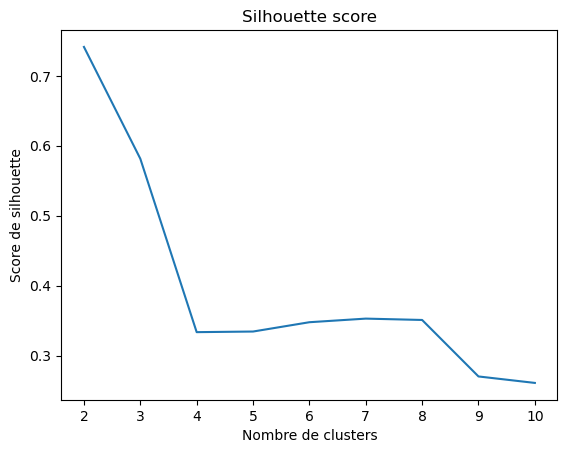

In [30]:
# Clustering dans le cas diabétiques
X_train = X_diabetes.values

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette score')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()

L'identification de deux ou trois groupes distincts parmi les patients atteints de diabète, basée sur les scores de silhouette, suggère qu'il existe des sous-populations au sein de cette cohorte qui partagent des caractéristiques similaires. Cette observation pourrait avoir des implications significatives dans la prise en charge médicale et le traitement des patients diabétiques. En considérant ces groupes identifiés, vous pourriez envisager d'adapter les stratégies de traitement en fonction des caractéristiques spécifiques de chaque groupe.

## Bilan

- Les modèles de détection du diabète obtiennent des performances moyennes et ont globalement plus de difficultés à identifier les personnes atteintes par le diabète que les personnes saines (rappel de 56% et précision de 66%).
- Malgré une légère amélioration des performances (rappel à 57%) avec un réseau de neurones, je pense qu'il faudrait conserver le KNN. Cette décision est motivée par une meilleure explicabilité du modèle.
- On distingue parmi les patients atteints par le diabète 2 à 3 sous-groupes. Il pourrait être intéressant de concevoir des traitements types pour ces sous-catégories afin d'améliorer l'efficacité de la prise en charge.

Piste d'améliorations :
1) Explorer différents modèles : Deep Learning; RandomForestClassifier; GradientBoostingClassifier
2) Validation croisée stratifiée, pour m'assurer que mon modèle est évalué de manière robuste sur les plis. Peut être que l'on ne sélectionne pas le meilleur paramètre k
3) Gestion des valeurs aberrantes : Je vais élaborer une stratégie pour gérer les valeurs aberrantes dans mon dataset, que ce soit par suppression, imputation, ou l'utilisation de modèles plus résistants.
4) Interprétation du modèle : Si la compréhension des prédictions est importante, je pourrais opter pour des modèles plus interprétables comme des arbres de décision.